# 1.线性回归从零开始

1. 人造数据集，生成1000个样本，两个特征，特征服从标准正态分布。设定参数W 和 b 的真实值，噪声因子服从均值为0，标准差为0.001的正态分布。
2. 生成数据的散点图

In [105]:
import random
import torch
from d2l import torch as d2l

In [131]:
def systhetic_data(w, b, n_samples):
    """生成数据集"""
    X = torch.normal(0, 1, (n_samples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [132]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = systhetic_data(true_w, true_b, 1000)

In [133]:
features.shape

torch.Size([1000, 2])

In [134]:
labels.shape

torch.Size([1000, 1])

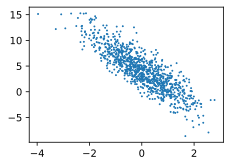

In [135]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

1. 数据集分为小批量的batch_size数据集
2. 打印小批量数据查看

In [136]:
def data_iter(features, labels, batch_size):
    num_samples = len(features)
    indices  = list(range(num_samples))
    random.shuffle(indices)
    for i in range(num_samples):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_samples)])
        yield features[batch_indices], labels[batch_indices]

In [137]:
batch_size = 10
for X, y in data_iter(features, labels, batch_size):
    print(X, '\n', y)
    break

tensor([[-0.4541,  0.2142],
        [-1.2086,  0.0992],
        [-1.0887, -1.5351],
        [-1.1357,  1.4590],
        [ 0.4816,  1.0742],
        [-1.3688,  1.1430],
        [-0.2043, -0.1069],
        [ 0.4456, -0.0126],
        [-0.6951,  0.3285],
        [-0.3004,  0.0867]]) 
 tensor([[ 2.5550],
        [ 1.4545],
        [ 7.2288],
        [-3.0376],
        [ 1.5029],
        [-2.4234],
        [ 4.1457],
        [ 5.1240],
        [ 1.6935],
        [ 3.3049]])


1.初始化参数，权重用均值为0，方差为0.001的正太分布随机初始化，偏置初始化为0.

In [138]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [139]:
w, b

(tensor([[-0.0052],
         [ 0.0166]], requires_grad=True),
 tensor([0.], requires_grad=True))

2. 定义线性回归模型

In [140]:
def linearmodel(X, w, b):
    """线性回归模型"""
    y = torch.matmul(X, w) + b
    return y

3. 定义平方损失函数

In [141]:
def square_loss(hat_y, y):
    """均方损失"""
    return (hat_y - y.reshape(hat_y.shape) ) ** 2 / 2

4. 优化模型

In [142]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad /batch_size
            param.grad.zero_()

5. 训练模型

In [143]:
# 设置超参数
lr = 0.03
num_epochs = 3
batch_size = 10

# 训练
for epoch in range(num_epochs):
    for X, y in data_iter(features, labels, batch_size):
        loss = square_loss(linearmodel(X, w, b), y)
        loss.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = square_loss(linearmodel(features, w, b), labels)
        print("Epoch_{} loss: {:f}".format(epoch + 1, float(train_l.mean())))

Epoch_1 loss: 0.000051
Epoch_2 loss: 0.000049
Epoch_3 loss: 0.000050


In [144]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([9.9063e-05, 1.3535e-03], grad_fn=<SubBackward0>)
b的估计误差: tensor([-0.0011], grad_fn=<RsubBackward1>)


# 2.线性回归的简洁实现

In [279]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

1. 数据集

In [280]:
ture_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

2. 使用框架中的API读取数据

   打印小批量数据查看

In [281]:
def load_array(data_array, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_array)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [282]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [283]:
next(iter(data_iter))

[tensor([[ 0.2945, -0.1859],
         [-1.0427, -1.2975],
         [ 0.6399, -0.6215],
         [-2.0292,  0.3497],
         [-0.0105,  3.1529],
         [-0.5800,  0.3995],
         [ 0.6338,  1.5059],
         [ 0.7364, -2.1098],
         [ 0.0559,  1.4438],
         [-0.7579, -0.1191]]),
 tensor([[ 5.4279],
         [ 6.5302],
         [ 7.6011],
         [-1.0635],
         [-6.5395],
         [ 1.6825],
         [ 0.3520],
         [12.8497],
         [-0.5914],
         [ 3.1081]])]

1. 定义模型

In [284]:
from torch import nn

In [285]:
net = nn.Sequential(nn.Linear(2, 1))

2. 初始化参数

In [286]:
# net[0].weight.data.normal_(0, 0.01)
# net[0].bias.data.fill_(0)
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

3. 定义损失函数
   
  平方L2范数

In [287]:
loss = nn.MSELoss()

4.定义优化算法

In [288]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

5.训练

In [292]:
num_epoches = 6
for epoch in range(num_epoches):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000101
epoch 2, loss 0.000102
epoch 3, loss 0.000102
epoch 4, loss 0.000101
epoch 5, loss 0.000103
epoch 6, loss 0.000101


In [295]:
# 访问训练获得的参数
w = net[0].weight.data
print("w的估计误差：{}".format(true_w - w.reshape(true_w.shape)))
b = net[0].bias.data
print("bias的估计误差：{}".format(true_b - b))

w的估计误差：tensor([-0.0001,  0.0003])
bias的估计误差：tensor([0.0003])


In [311]:
# 访问模型中参数的梯度
net[0].weight.grad, net[0].bias.grad

(tensor([[ 9.7936e-03, -1.8336e-05]]), tensor([-0.0031]))